In [1]:
import sys
import os
sys.path.append('/Users/cosinga/code/sparta_dev/analysis/build/lib/')
from sparta_tools import moria, sparta
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import re

# paths
BASE = '/Users/cosinga/code/'
SIMPATH = '/Users/cosinga/sims/sparta_output/'
MORIA_FILE = 'moria_tree_cbol_l0063_n0256_no_cuts.hdf5'
SIMNAME = 'L0063_N0256_CBol'
SPARTA_FILE = 'sparta_no_cuts.hdf5'
ROCKSTAR_FILE = '/Users/cosinga/sims/nbody/cbol_l0063_n0256/rockstar_trees_200m_bnd/tree_0_0_0.dat'
# verbosity - 1 includes print statemtents, 
# 2 breaks after one halo (with at least one tracer)
V = 2
V_COUNT = 50
# desired quantities
RADIUS_DEF = 'R200m_bnd_cat'
MASS_DEF = 'M' + RADIUS_DEF[1:]
mdata = moria.load(
    SIMPATH + '%s/%s'%(SIMNAME, MORIA_FILE), 
    [RADIUS_DEF, MASS_DEF, 'mask_alive', 'x', 'id',
     'phantom', 'parent_id_cat', 'parent_id_orbinf',
     'scale_of_last_MM', 'status_sparta']
)

sdata = sparta.load(
    SIMPATH + '%s/%s'%(SIMNAME, SPARTA_FILE), load_halo_data = True,
    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
    res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True
)

rdata = np.loadtxt(ROCKSTAR_FILE)
f = open(ROCKSTAR_FILE, 'r')
line = f.readline()
line = re.sub(r'\(\d+\)', '', line)
rhead = line[1:].split(' ')
print(rhead)

spmr = pkl.load(open('sporstar.pkl', 'rb'))
print(spmr.keys())

sparta.load: Loading file /Users/cosinga/sims/sparta_output/L0063_N0256_CBol/sparta_no_cuts.hdf5.
sparta.load: Loading 38867/38867 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 3887/38867
sparta.load: Matching result IDs in tracer sho, halo 7773/38867
sparta.load: Matching result IDs in tracer sho, halo 11659/38867
sparta.load: Matching result IDs in tracer sho, halo 15545/38867
sparta.load: Matching result IDs in tracer sho, halo 19431/38867
sparta.load: Matching result IDs in tracer sho, halo 23317/38867
sparta.load: Matching result IDs in tracer sho, halo 27203/38867
sparta.load: Matching result IDs in tracer sho, halo 31089/38867
sparta.load: Matching result IDs in tracer sho, halo 34975/38867
sparta.load: Matching result IDs in tracer sho, halo 38861/38867
['scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_M200b', 'M200b', 'R200b', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM', 'vmax', 'x', 'y'

In [2]:
# renaming symbols
tjy = sdata['tcr_sho']['res_tjy']
ifl = sdata['tcr_sho']['res_ifl']
oct = sdata['tcr_sho']['res_oct']
hdata = sdata['halos']
boxsize = sdata['simulation']['box_size']
nhalos = len(hdata['sho_oct_first'])
nsnaps = sdata['simulation']['n_snaps']
snap_z = sdata['simulation']['snap_z']
snap_a = sdata['simulation']['snap_a']
res_lim = 200 * sdata['simulation']['particle_mass']
snaps = np.arange(nsnaps)
ntcrs = tjy.shape[0]
boxsize = sdata['simulation']['box_size']

temp = {}
for i, key in enumerate(rhead):
    temp[key] = rdata[:, i]
rdata = temp


In [3]:
mdata['status_sparta']

array([[10,  0,  0, ...,  0,  0,  0],
       [10,  0,  0, ...,  0,  0,  0],
       [10,  0,  0, ...,  0,  0,  0],
       ...,
       [10, 20, 20, ..., 10, 10, 10],
       [10, 20, 20, ..., 10, 10, 10],
       [10, 20, 20, ..., 10, 10, 10]], dtype=int8)

In [4]:
# simple check to see if the number of halos in moria and the tree match
print('number of halos')
print(rdata['M200b'].shape[0], mdata['mask_alive'].sum())
print('number of subhalos')
rsub_count = (rdata['pid'] > 0).sum()
msub_count = (mdata['parent_id_cat'] > 0).sum()
print(rsub_count, msub_count)


number of halos
2704376 2704376
number of subhalos


324665 324665


In [5]:
print("how many sparta halos are missing an equivalent host in MORIA? (error rate)")
not_found = (spmr['host_midx'] < 0)
print(not_found.sum(), not_found.sum() / ntcrs)

how many sparta halos are missing an equivalent host in MORIA? (error rate)
0 0.0


In [6]:
print("number of tracers that did not have equivalent moria halo")
not_found = (spmr['tcr_midx'] < 0)
print(not_found.sum(), not_found.sum() / ntcrs)

number of tracers that did not have equivalent moria halo
0 0.0


# How many host-tracer pairs do not have an equivalent parent-subhalo pair?

In [7]:


no_ps_match = np.zeros(ntcrs, dtype = bool)
no_ps_snaps = np.zeros((ntcrs, nsnaps), dtype = bool)

for i in range(ntcrs):

    tcr_midx = spmr['tcr_midx'][i] # all tracers are found in moria
    tcr_sidx = spmr['tcr_sidx'][i] 
    hst_midx = spmr['host_midx'][i] # all hosts are found in moria

    fsnap = tjy['first_snap'][tcr_sidx]
    lsnap = tjy['last_snap'][tcr_sidx]

    host_ids = mdata['id'][:, hst_midx]
    sub_pids = mdata['parent_id_cat'][:, tcr_midx]

    no_match_mask = np.logical_not(host_ids[fsnap:lsnap] == sub_pids[fsnap:lsnap])
    no_ps_match[i] = np.all(no_match_mask)
    if np.all(no_match_mask):
        no_ps_snaps[i, fsnap:lsnap] = no_match_mask

print(no_ps_match.sum())
print(np.where(no_ps_snaps))





1392
(array([   38,    41,    41, ..., 28041, 28041, 28041]), array([ 24,  26,  27, ..., 163, 164, 165]))


/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_31401/2379077115.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(snaps, no_ps_count / tcr_count * 100)


Text(0.5, 0, 'snapshot')

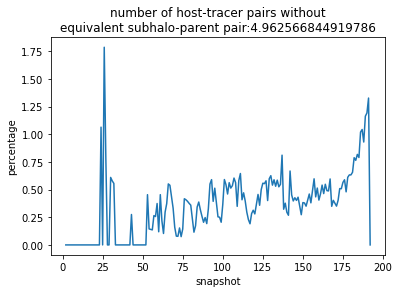

In [8]:
tcr_count = np.zeros(nsnaps)

for i in range(nsnaps):
    tcr_mask = ((tjy['first_snap'] <= i) & (tjy['last_snap'] >= i))
    tcr_count[i] = tcr_mask.sum()

no_ps_count = np.sum(no_ps_snaps, axis = 0)
plt.plot(snaps, no_ps_count / tcr_count * 100)
tot_nops = no_ps_match.sum() / ntcrs * 100
plt.title(f"number of host-tracer pairs without\nequivalent subhalo-parent pair:{tot_nops}")
plt.ylabel('percentage')
plt.xlabel('snapshot')

## According to moria, do these subhalos ever reach with R200m_bnd of supposed parent?

In [9]:
def unwrapPositions(positions, alives, boxsize):
        """
        Since the positions of the trackers are logged in a periodic
        box, the positions are wrapped when they cross the boundary
        of the box. This function unwraps their positions, allowing
        for their positions to be displayed continuously

        Args:
            
        """
        # first determine if unwrapping is necessary

        # if the range of positions is greater than L/2, then
        # unwrapping is needed
        pos_range = np.zeros((3, 2))
        pos_range[:, 0] = boxsize
        for i in range(len(positions)):
            pos = positions[i][alives[i], :]
            for j in range(pos_range.shape[0]):
                posmin = np.min(pos[:, j])
                posmax = np.max(pos[:, j])
                pos_range[j, 0] = min(posmin, pos_range[j, 0])
                pos_range[j, 1] = max(posmax, pos_range[j, 1])
        
        sub_pos = positions[0].copy()
        host_pos = positions[1].copy()
        for a in range(pos_range.shape[0]):
            if pos_range[a, 1] - pos_range[a, 0] >= boxsize / 2:
                unwrap_mask = sub_pos[:, a] <= boxsize / 2
                sub_pos[unwrap_mask & alives[0], a] += boxsize
                unwrap_mask = host_pos[:, a] <= boxsize / 2
                host_pos[unwrap_mask & alives[1], a] += boxsize

        return sub_pos, host_pos

In [10]:


def plot_sparta_host_rad(i):
    hst_sidx = spmr['host_sidx'][i]
    
    host_rad = hdata['R200m'][hst_sidx]
    host_valid = host_rad > 0

    plt.scatter(snaps[host_valid], host_rad[host_valid], color = 'blue', label = 'host R200m')
    return

def plot_sparta_dist(i):
    tcr_sidx = spmr['tcr_sidx'][i]

    snap_slc = tjy['r'][tcr_sidx] > 0
    plt.scatter(snaps[snap_slc], tjy['r'][tcr_sidx, snap_slc], label = 'sparta r', color = 'orange')
    return tjy['r'][tcr_sidx, :]

def plot_pericenter(i, ylim):

    tcr_sidx = spmr['tcr_sidx'][i]
    nperi = oct['n_pericenter'][tcr_sidx]
    nlowlim = oct['n_is_lower_limit'][tcr_sidx]
    peri_snap = oct['last_pericenter_snap'][tcr_sidx]
    if nperi > 0 or nlowlim == 1:
        # plt.scatter(peri_snap, r_tcr[peri_snap], color = 'pink', marker='X', label = 'pericenter')
        plt.axvline(peri_snap, 0, ylim[1], color = 'red', label = 'pericenter')
        return True
    else:
        return False




    

In [37]:
def plot_moria_host_rad(i):
    hst_midx = spmr['host_midx'][i]
    hst_alv = mdata['mask_alive'][:, hst_midx]

    host_rad_mo = mdata[RADIUS_DEF][hst_alv, hst_midx]
    plt.plot(snaps[hst_alv], host_rad_mo, color = 'blue', label = 'moria R200m_bnd_cat of host')
    return

def plot_moria_dist(i):
    tcr_midx = spmr['tcr_midx'][i]
    hst_midx = spmr['host_midx'][i]
    
    tcr_alv = mdata['mask_alive'][:, tcr_midx]
    hst_alv = mdata['mask_alive'][:, hst_midx]
    both_alv = tcr_alv & hst_alv

    tcr_x = mdata['x'][:, tcr_midx, :]
    hst_x = mdata['x'][:, hst_midx, :]
    tcr_x, hst_x = unwrapPositions([tcr_x, hst_x], [tcr_alv, hst_alv], boxsize)
    dist = np.linalg.norm(tcr_x - hst_x, axis = 1)
    plt.plot(snaps[both_alv], dist[both_alv] * 1e3 * snap_a[both_alv], color = 'orange', label = 'moria r')
    return dist * 1e3 * snap_a


# def plot_moria_host_is_sub(i, ylim):
#     hst_midx = spmr['host_midx'][i]
#     hst_pids = mdata['parent_id_cat'][:, hst_midx]
#     is_sub = hst_pids > 0
#     sub_snaps = np.where(is_sub)[0]
#     starts = [sub_snaps[0]]
#     stops = [sub_snaps[-1]]
#     for j in range(len(sub_snaps) - 1):
#         if not sub_snaps[j] == sub_snaps[j + 1]:
#             stops.append(sub_snaps[j])
#             starts.append(sub_snaps[j + 1])
#     for ss in range(len(starts)):
#         if ss == 0:
#             kwargs = dict(alpha = 0.5, color = 'gray', label = 'host is sub')
#         else:
#             kwargs = dict(alpha = 0.5, color = 'gray')
#         if not starts[ss] == stops[ss]:
#             plt.fill_betweenx(ylim, starts[ss], stops[ss], **kwargs)
#         else:
#             plt.fill_betweenx(ylim, starts[ss] - 0.5, stops[ss] + 0.5, **kwargs)
#     return
def _status_to_string(status):
    if status == -1:
        return 'none'
    elif status == -2:
        return 'not found'
    elif status == 10:
        return 'host'
    elif status == 20:
        return 'sub'
    elif status == 21:
        return 'h->s'
    elif status == 22:
        return 's->h'
    elif status == 23:
        return 's1->h'
    elif status == 24:
        return 'switch'
    elif status == 50:
        return 'merged'
    elif status == 72:
        return 'h->X'
    
def plot_moria_host_status(i):
    hst_midx = spmr['host_midx'][i]
    alv = mdata['mask_alive'][:, hst_midx]
    hst_status = mdata['status_sparta'][alv, hst_midx]
    snaps_alv = snaps[alv]
    host_rad = mdata[RADIUS_DEF][alv, hst_midx]
    for j in range(len(snaps_alv)):
        if j == 0:
            make_annot = True
        elif not hst_status[j - 1] == hst_status[j]:
            make_annot = True
        else:
            make_annot = False
        
        if make_annot:
            ant = _status_to_string(hst_status[j])

            x = snaps_alv[j]
            y = host_rad[j]
            plt.annotate(
                text = ant,
                xy = (x, y),
                xycoords = 'data',
                xytext = (0, 10),
                textcoords='offset points',
                ha = 'center',
                va = 'top'
            ) 
            
    return

def plot_moria_sub_status(i, mdist):
    tcr_midx = spmr['tcr_midx'][i]
    alv = mdata['mask_alive'][:, tcr_midx]
    snaps_alv = snaps[alv]
    sub_status = mdata['status_sparta'][alv, tcr_midx]
    for j in range(len(snaps_alv)):
        if j == 0:
            make_annot = True
        elif not sub_status[j - 1] == sub_status[j]:
            make_annot = True
        else:
            make_annot = False
        
        if make_annot:
            ant = _status_to_string(sub_status[j])

            x = snaps_alv[j]
            y = mdist[alv][j]
            plt.annotate(
                text = ant,
                xy = (x, y),
                xycoords = 'data',
                xytext = (0, -10),
                textcoords='offset points',
                ha = 'center',
                va = 'bottom'
            ) 



    

In [38]:
# making radius plots
pstcr_idxs = np.where(no_ps_match)[0]
has_peri = np.zeros(ntcrs, dtype = bool)
for i in pstcr_idxs:
    # create matplotlib figure, axes
    # fig, axes = plt.subplots(1, 2, sharey=True, figsize = (8, 4))
    fig = plt.figure(facecolor='white', figsize = (8,8))
    mdist = plot_moria_dist(i)
    plot_moria_host_rad(i)
    sdist = plot_sparta_dist(i)
    plot_sparta_host_rad(i)
    has_peri[i] = plot_pericenter(i, plt.ylim())
    plot_moria_host_status(i)
    plot_moria_sub_status(i, mdist)
    plt.ylabel('radius (kpc / h)')

    plt.xlabel('snapshot')
    plt.legend(loc = (1, 0.5))

    plt.title(f"tracer idx = {i}")
    plt.savefig(f'as_tcr_rad_plots/{i}.png', bbox_inches = 'tight', facecolor = 'auto')
    plt.clf()
    plt.close()
print('fraction of host-tracer pairs w/out parent-sub eqv that have pericenters')
print(has_peri.sum() / len(pstcr_idxs))

fraction of host-tracer pairs w/out parent-sub eqv that have pericenters
0.1910919540229885


## comparing moria and rockstar now

In [ ]:
# making radius plots
pstcr_idxs = np.where(no_ps_match)[0]
for i in pstcr_idxs:
    # create matplotlib figure, axes
    # fig, axes = plt.subplots(1, 2, sharey=True, figsize = (8, 4))
    tcr_midx = spmr['tcr_midx'][i]
    hst_midx = spmr['host_midx'][i]

    tcr_alv = mdata['mask_alive'][:, tcr_midx]
    hst_alv = mdata['mask_alive'][:, hst_midx]
    both_alv = tcr_alv & hst_alv
    
    host_rad_mo = mdata[RADIUS_DEF][hst_alv, hst_midx]

    tcr_x = mdata['x'][:, tcr_midx, :]
    hst_x = mdata['x'][:, hst_midx, :]
    tcr_x, hst_x = unwrapPositions([tcr_x, hst_x], [tcr_alv, hst_alv], boxsize)

    plt.plot()

    tcr_ridx = spmr['tcr_ridx'][i]
    tcr_ridx = tcr_ridx[tcr_ridx >= 0]
    hst_ridx = spmr['host_ridx'][i]
    hst_ridx = hst_ridx[hst_ridx >= 0]


    

In [51]:
rdata['id'][spmr['tcr_ridx'][0]]

array([5.133020e+05, 4.949150e+05, 4.768560e+05, 4.591200e+05,
       4.417150e+05, 4.246520e+05, 4.079270e+05, 3.915520e+05,
       3.755100e+05, 3.598400e+05, 3.444730e+05, 3.295120e+05,
       3.149180e+05, 3.007070e+05, 2.868570e+05, 2.733440e+05,
       2.601850e+05, 2.474050e+05, 2.350370e+05, 2.230900e+05,
       2.114940e+05, 2.003260e+05, 1.894940e+05, 1.790470e+05,
       1.689600e+05, 1.592390e+05, 1.499520e+05, 1.409690e+05,
       1.323270e+05, 1.240390e+05, 1.160890e+05, 1.085190e+05,
       1.013010e+05, 9.440500e+04, 8.783300e+04, 8.157000e+04,
       7.561300e+04, 6.997900e+04, 6.462000e+04, 5.955100e+04,
       5.479100e+04, 5.034200e+04, 4.617100e+04, 4.228800e+04,
       3.862300e+04, 3.518800e+04, 3.197300e+04, 2.896800e+04,
       2.618900e+04, 2.362700e+04, 2.124800e+04, 1.905900e+04,
       1.705800e+04, 1.519800e+04, 1.348300e+04, 1.194200e+04,
       1.052300e+04, 9.234000e+03, 8.057000e+03, 6.977000e+03,
       6.016000e+03, 5.145000e+03, 4.356000e+03, 3.6520